<a href="https://www.kaggle.com/code/vanpatangan/predict-future-sales?scriptVersionId=219634234" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# import libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# load data

In [2]:
sales_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

# data summary

In [3]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Compute values that are constant across columns
    total_rows = len(df)
    duplicates = df.duplicated().sum()

    # Use vectorized operations 
    dtypes = df.dtypes
    instances = df.count()
    unique = df.nunique()
    sum_null = df.isnull().sum()

    # Create the summary 
    df_check = pd.DataFrame({
        'column': df.columns,
        'dtype': dtypes,
        'instances': instances,
        'unique': unique,
        'sum_null': sum_null,
        'duplicates': duplicates  
    })

    return df_check

print("Sales Train")
display(check(sales_train))
display(sales_train.head())

print("Items")
display(check(items))
display(items.head())

print("Item Categories")
display(check(item_categories))
display(item_categories.head())

print("Shops")
display(check(shops))
display(shops.head())

print("Test")
display(check(test_df))
display(test_df.head())

Sales Train


,column,dtype,instances,unique,sum_null,duplicates
date,date,object,2935849,1034,0,6
date_block_num,date_block_num,int64,2935849,34,0,6
shop_id,shop_id,int64,2935849,60,0,6
item_id,item_id,int64,2935849,21807,0,6
item_price,item_price,float64,2935849,19993,0,6
item_cnt_day,item_cnt_day,float64,2935849,198,0,6


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,1709.05,1.00
4,15.01.2013,0,25,2555,1099.00,1.00


Items


,column,dtype,instances,unique,sum_null,duplicates
item_name,item_name,object,22170,22170,0,0
item_id,item_id,int64,22170,22170,0,0
item_category_id,item_category_id,int64,22170,84,0,0


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Item Categories


,column,dtype,instances,unique,sum_null,duplicates
item_category_name,item_category_name,object,84,84,0,0
item_category_id,item_category_id,int64,84,84,0,0


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Shops


,column,dtype,instances,unique,sum_null,duplicates
shop_name,shop_name,object,60,60,0,0
shop_id,shop_id,int64,60,60,0,0


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


Test


,column,dtype,instances,unique,sum_null,duplicates
ID,ID,int64,214200,214200,0,0
shop_id,shop_id,int64,214200,42,0,0
item_id,item_id,int64,214200,5100,0,0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# merge

In [4]:
# Merge sales_train with items
train = sales_train.merge(items, on='item_id', how='left')

# Merge the result with item_categories
train = train.merge(item_categories, on='item_category_id', how='left')

# Merge the result with shops
train = train.merge(shops, on='shop_id', how='left')

In [5]:
# Convert date column to datetime 
train['date'] = pd.to_datetime(train['date'], dayfirst=True)

# EDA visualization

In [ ]:
# Distribution plots for item_price and item_cnt_day
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(train['item_price'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Item Price')
axes[0].set_xlabel('Item Price')

sns.histplot(train['item_cnt_day'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Item Count per Day')
axes[1].set_xlabel('Item Count per Day')

plt.tight_layout()
plt.show()

In [ ]:
# Boxplots for outlier detection
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(y=train['item_price'], ax=axes[0])
axes[0].set_title('Boxplot of Item Price')

sns.boxplot(y=train['item_cnt_day'], ax=axes[1])
axes[1].set_title('Boxplot of Item Count per Day')

plt.tight_layout()
plt.show()

In [ ]:
# Compute correlation matrix
correlation_matrix = train[['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Total sales per month
monthly_sales = train.groupby('date_block_num')['item_cnt_day'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales, x='date_block_num', y='item_cnt_day')
plt.title('Total Sales Over Time (Monthly)')
plt.xlabel('Date Block Number')
plt.ylabel('Total Sales')
plt.show()

# Top 10 shops by total sales
top_shops = train.groupby('shop_name')['item_cnt_day'].sum().sort_values(ascending=False).head(10)
top_shops.plot(kind='bar', figsize=(10, 6), title='Top 10 Shops by Sales')
plt.ylabel('Total Sales')
plt.show()

# Top 10 categories by total sales
top_categories = train.groupby('item_category_name')['item_cnt_day'].sum().sort_values(ascending=False).head(10)
top_categories.plot(kind='bar', figsize=(10, 6), title='Top 10 Categories by Sales')
plt.ylabel('Total Sales')
plt.show()


# handle outliers

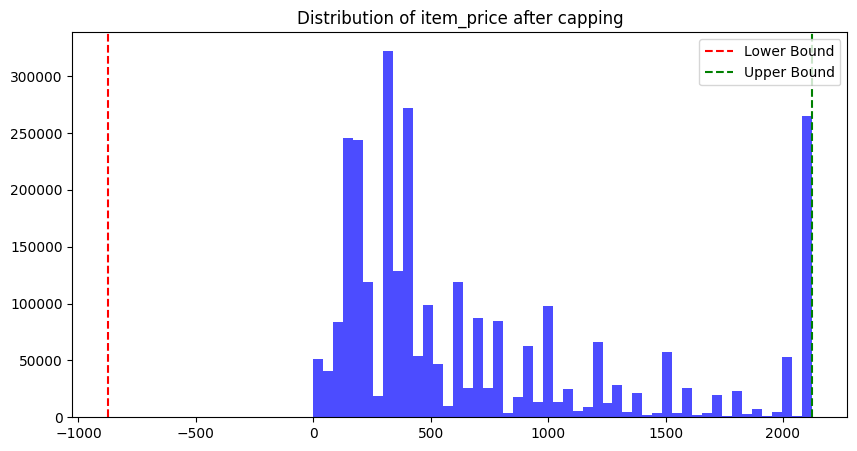

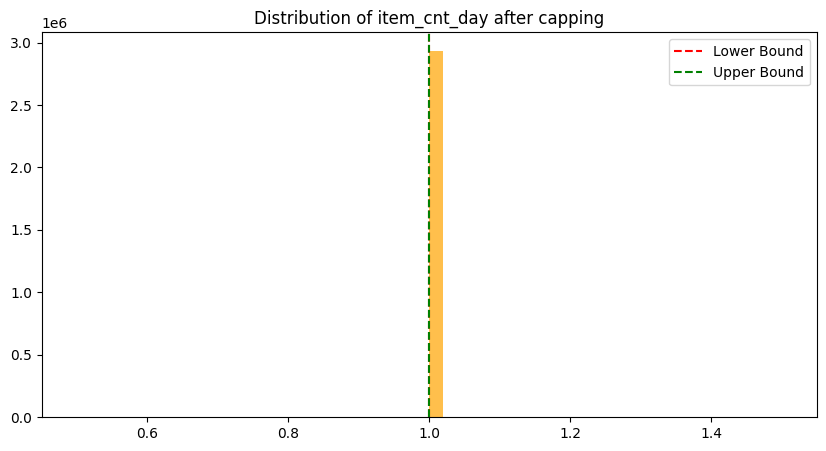

In [6]:
# Calculate IQR for item_price
Q1_price = train['item_price'].quantile(0.25)
Q3_price = train['item_price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
price_lower = Q1_price - 1.5 * IQR_price
price_upper = Q3_price + 1.5 * IQR_price

# Calculate IQR for item_cnt_day
Q1_cnt = train['item_cnt_day'].quantile(0.25)
Q3_cnt = train['item_cnt_day'].quantile(0.75)
IQR_cnt = Q3_cnt - Q1_cnt
cnt_lower = Q1_cnt - 1.5 * IQR_cnt
cnt_upper = Q3_cnt + 1.5 * IQR_cnt

# Cap outliers for item_price
train['item_price'] = train['item_price'].clip(lower=price_lower, upper=price_upper)

# Cap outliers for item_cnt_day
train['item_cnt_day'] = train['item_cnt_day'].clip(lower=cnt_lower, upper=cnt_upper)

# Plot for item_price
plt.figure(figsize=(10, 5))
plt.hist(train['item_price'], bins=50, color='blue', alpha=0.7)
plt.axvline(price_lower, color='red', linestyle='--', label='Lower Bound')
plt.axvline(price_upper, color='green', linestyle='--', label='Upper Bound')
plt.title('Distribution of item_price after capping')
plt.legend()
plt.show()

# Plot for item_cnt_day
plt.figure(figsize=(10, 5))
plt.hist(train['item_cnt_day'], bins=50, color='orange', alpha=0.7)
plt.axvline(cnt_lower, color='red', linestyle='--', label='Lower Bound')
plt.axvline(cnt_upper, color='green', linestyle='--', label='Upper Bound')
plt.title('Distribution of item_cnt_day after capping')
plt.legend()
plt.show()

# feature engineer

In [7]:
# Create target variable
# Aggregate by date_block_num, item_id, and shop_id
item_cnt_month = train.groupby(['date_block_num', 'item_id', 'shop_id'])['item_cnt_day'].sum().reset_index()

# Rename column for clarity
item_cnt_month.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

# Merge item_cnt_month back to the main dataframe
train = train.merge(item_cnt_month, on=['date_block_num', 'item_id', 'shop_id'], how='left')

# Now item_cnt_month contains the total sales per item per shop per month

In [ ]:
""""
# Unique counts
num_shops = train['shop_id'].nunique()
num_items = train['item_id'].nunique()
num_categories = train['item_category_id'].nunique()

print(f"Number of Shops: {num_shops}")
print(f"Number of Items: {num_items}")
print(f"Number of Categories: {num_categories}")

# Average sales per shop
avg_sales_per_shop = train.groupby('shop_name')['item_cnt_day'].mean().sort_values(ascending=False)
print(avg_sales_per_shop.head(10))


In [10]:
# Aggregating historical performance
shop_avg_sales = train.groupby('shop_id')['item_cnt_day'].mean().rename('shop_avg_sales')
category_avg_sales = train.groupby('item_category_id')['item_cnt_day'].mean().rename('category_avg_sales')

train = train.merge(shop_avg_sales, on='shop_id', how='left')
train = train.merge(category_avg_sales, on='item_category_id', how='left')

In [ ]:
""""
# Maybe delete this since we handled negative values already
negative_values = merged_df[merged_df['item_cnt_day'] < 0]['item_cnt_day']
negative_count = len(negative_values)

print(f"Number of negative values: {negative_count}")
print("Negative values:")
print(negative_values)

# time features

In [ ]:
# align test and merged_df except the target column item_cnt_day

In [ ]:
# Copy Id for submission
test_id = test_df['ID'].copy()

# Identify columns present in train_df but not in test_df 
missing_columns = set(train_df.columns) - set(test_df.columns) - {'item_cnt_day'}

# Add missing columns to test_df with default values 0
for col in missing_columns:
    test_df[col] = 0  

# Ensure both dataframes have the same column order 
common_columns = [col for col in train_df.columns if col in test_df.columns and col != 'item_cnt_day']

# Reorder columns
train_df = train_df[common_columns + ['item_cnt_day']]
test_df = test_df[common_columns]

# Verify that the columns are aligned 
assert set(train_df.columns) == set(test_df.columns).union({'item_cnt_day'}), "Columns do not match"

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label encode object dtype columns
le = LabelEncoder()
object_cols = train_df.select_dtypes(include='object').columns
for col in object_cols:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.fit_transform(test_df[col])

# modeling

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Define the feature set and target variable
X = train_df.drop(['item_cnt_day', 'date'], axis=1)
y = train_df['item_cnt_day']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  random_state=42)
# Define parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [31],
    'learning_rate': [0.05],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [-1]
}

# Initialize LightGBM regressor
lgb_estimator = lgb.LGBMRegressor(objective="regression", metric="rmse", seed=1)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, 
                           cv=3, scoring='neg_root_mean_squared_error', verbose=-1, 
                           n_jobs=-1)

# Fit the Grid Search
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params = grid_search.best_params_
print("Best parameters found by Grid Search:", best_params)

# Train the final model with the best parameters
final_model = lgb.LGBMRegressor(**best_params, objective="regression", metric="rmse", seed=1)
final_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = final_model.predict(X_val)

# Evaluate the final model
mse_final = mean_squared_error(y_val, y_pred)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_val, y_pred)

print("Final Model RMSE:", rmse_final)
print("Final Model R-squared:", r2_final)

# predict on test set

In [ ]:
# Drop date
X_test = test_df.drop(['date'], axis=1)

# Check the test set has the same columns as the training set
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

# Predict on the test dataset
y_test_pred = final_model.predict(X_test)

# submission

In [ ]:
# Save the predictions
predictions_df = pd.DataFrame({'id': test_id, 'item_cnt_month': y_test_pred})

# Save predictions to a CSV file
predictions_df.to_csv('submission.csv', index=False)

# Display the first few rows of the predictions
predictions_df.head()